# Predicting star ratings from Amazon Reviews

This is my first-ever project in NLP, so I decided to not get ahead of myself and follow a couple of tutorials and play around with them a little. Those tutorials are linked at the end.
**Objective:** In this project, I will try to build a classifier to predict what rating out of 5 a user will give to a product on Amazon, based on his/her review.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To make this notebook easier to read, I've collapsed all the code by default. If you want to toggle
displaying the code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## The data
The dataset chosen is a small collection of reviews of Amazon products, primarily Alexa. The link to the dataset is now broken for some reason, but I have uploaded it in the same repositiory.
First, let's take a look at the data:

In [3]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings; warnings.simplefilter('ignore')

In [4]:
reviews = pd.read_csv('/home/ab/Downloads/Datasets for analysis/Amazon reviews/amazon_alexa.tsv', sep = '\t', quotechar = '"')
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.1+ KB


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


There are no null values in the dataset, which is good. There are only 3150 reviews in the dataset, which means it will be harder for a model to extract meaning out of it.
Here's a look at how the ratings are distributed:

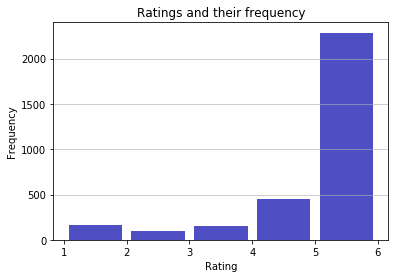

In [5]:
#Let's look at the distribution of reviews
n, bins, patches = plt.hist(x=reviews.rating, bins=[1,2,3,4,5,6], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings and their frequency')
maxfreq = n.max()

The number of 5-star reviews there is overwhelmingly high. This could cause problems down the line, but I'll keep it for now.

## Review Polarity

Before trying to predict the actual rating, it makes sense to see if I can at least predict the *polarity* of a review - it makes no sense trying to predict how many stars a reviewer will give if we can't even judge whether it's a positive or negative review.
For this, I'll remove all the 3-star reviews (make your mind up, people! Do you like it or not?) - and create a column called polarity - one for positive, zero for negative.

In [6]:
polar_reviews = reviews.loc[:,['rating','verified_reviews']].query("rating < 3 or rating > 3")
polar_reviews['polarity'] = np.random.randn(len(polar_reviews.verified_reviews))
#print(polar_reviews.head())
polar_reviews['polarity'].loc[(polar_reviews['rating'] == 5) | (polar_reviews['rating'] == 4)] = 1
polar_reviews['polarity'].loc[(polar_reviews['rating'] == 2) | (polar_reviews['rating'] == 1)] = 0
#print(polar_reviews.head())
print(polar_reviews.head())

   rating                                   verified_reviews  polarity
0       5                                      Love my Echo!       1.0
1       5                                          Loved it!       1.0
2       4  Sometimes while playing a game, you can answer...       1.0
3       5  I have had a lot of fun with this thing. My 4 ...       1.0
4       5                                              Music       1.0


This is the column that I'm now going to try and predict. First, I'll use the same text processing function as in the tutorial to remove punctuations and stopwords. Here's what our text processing function does:

In [7]:
x = polar_reviews['verified_reviews']
y = polar_reviews['polarity']

def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''

    remove_punctuation = [char for char in text if char not in string.punctuation]

    remove_punctuation = ''.join(remove_punctuation)
    
    return [word for word in remove_punctuation.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

sample = "Six Seasons and a movie!"
print('A sample sentence: ',sample,'\n')
print('Output from our text processing function: ')
print(text_process(sample))

A sample sentence:  Six Seasons and a movie! 

Output from our text processing function: 
['Six', 'Seasons', 'movie']


At this point, I tried using combinations of a Bag-of-Words vectorizer and TF-IDF, with a Naive Bayes classifier and an SVM.
I'll try to give a brief summary of what all of those words mean.

- Bag-of-words is where I simply consider each review as a combination of its constituent (minus the useless words like 'and' and 'an', of course), and the classifier then tries, based on the words in each 'bag', to classify if its positive or negative. An intuitive explanation can be found [here](https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428).
- TF-IDF is more advanced than that - it normalizes the times each word occurs by the *total* number of times it occurs in the entire document. After all, the important words are the ones you see often, but not *too* often. The [Wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for TF-IDF is pretty explanatory.
- Naive Bayes sounds like a fancy classifier but it's not - [here](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) is a lucid and intuitive explanation of it. It starts off assuming each word to be independent, and simply uses Bayes theorem to improve its classification of each text, word by word. Naive Bayes works on understanding what it doesn't know. Naive Bayes is good. Be like Naive Bayes.
- [Here](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf) is a simple guide to SVMs.
In the cell below, I've commented out all the code for all of these. Take a look at the f1 scores in all four cases:

In [8]:
#bow_transformer = CountVectorizer(analyzer=text_process).fit(x)
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer(ngram_range=(1,2))
#X = vectorizer.fit_transform(x)
#len(bow_transformer.vocabulary_)
#review_255 = x[255]
#print(review_255)
#bow_25 = bow_transformer.transform([review_255])
#print(bow_25)
#print(bow_transformer.get_feature_names()[1143])
#X = bow_transformer.transform(x)
#print(vectorizer.get_feature_names()[1143])
#X = vectorizer.fit_transform(x)
#print('Shape of Sparse Matrix: ', X.shape)
#print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
#density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017, stratify = y)
#from sklearn.naive_bayes import MultinomialNB
#nb = MultinomialNB()
#nb.fit(X_train, y_train)
#Import svm model
#from sklearn import svm
#Create a svm Classifier
#clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
#clf.fit(X_train, y_train)
#predictions = nb.predict(X_test)
#from sklearn.metrics import confusion_matrix, classification_report

#print(confusion_matrix(y_test, predictions))
#print('\n')
#print(classification_report(y_test, predictions))

In [9]:
f1 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data=[['TF-IDF','SVM','91%']])
f2 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data=[['TF-IDF','Naive Bayes','87%']])
f1 = f1.append(f2)
f3 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data= [['Bag-of-words','Naive Bayes','93%']])
f1 = f1.append(f3)
f4 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data= [['Bag-of-words','SVM','94%']])
f1 = f1.append(f4)
f1

,Vectoriser,Classification Algorithm,F1 Score
0,TF-IDF,SVM,91%
0,TF-IDF,Naive Bayes,87%
0,Bag-of-words,Naive Bayes,93%
0,Bag-of-words,SVM,94%


Looks pretty good, right?

Well, not so fast. There are a few problems here. Bag-of-words performing better than TF-IDF is, in my opinion, a sign that either the reviews are too short (and thus giving less information to n-grams) or that the dataset is too small for the IDF term to have any real effect.
More importantly, if you look at the precision and recall of any one of these (for example, the one that uses TF-IDF with an SVM), you'll see this:

             precision    recall  f1-score   support

        0.0       1.00      0.22      0.36        77
        1.0       0.93      1.00      0.96       823

avg / total       0.94      0.93      0.91       900

The number of predictions for polarity = 0 is way too low.

For TF-IDF with Naive Bayes, it's completely out of whack:

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        77
        1.0       0.91      1.00      0.96       823

avg / total       0.84      0.91      0.87       900

This is the problem caused by the distribution of the dependent variable being heavily skewed - The naive bayes algorithm doesn't classify anything as negative polarity at all, and still gets away with 87% accuracy!


## The data : part deux

To solve the problems with the earlier data, I decided to work with another dataset, the [amazon fine food reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews). This dataset has more than 568k reviews, the vectorisation of which had been running for 7 hours (and counting) when I took mercy on my poor old laptop.

So I've subsetted a portion of the data, and I used the 'splitstackshape' package in R to stratify it and select 5k reviews of each class.

Here's a look at the new data:


In [10]:
#New Data
food_reviews = pd.read_csv('/home/ab/Downloads/amazon-fine-food-reviews/stratified_reviews.csv', sep = ',', quotechar = '"')
print(food_reviews.head())

   Unnamed: 0      Id   ProductId          UserId     ProfileName  \
0           1  526171  B006ABD3DY  A19THLC5ICNIKV         artlady   
1           2  308012  B001BS4G6O   AOA0GQX1RWKT1      Janet Chou   
2           3  269420  B000P41A46  A3Q2SN758CPI16  Cornelia Stutz   
3           4  166115  B001CWV4RS  A2J1MM9A9F9LX9          Lisa S   
4           5  439179  B004IJHY4Y  A2KZVGG2PS3WB3        Tsclower   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     4                       4      5  1331596800   
1                     1                       1      5  1230422400   
2                     0                       0      5  1347926400   
3                     0                       0      5  1209600000   
4                     4                       4      5  1287360000   

                                             Summary  \
0                                  salt of the earth   
1  It takes away the aggravation in feeding your ...

And the distribution of ratings:

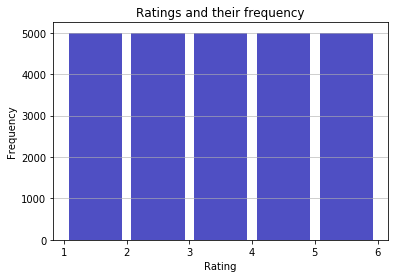

In [11]:
n, bins, patches = plt.hist(x=food_reviews.Score, bins=[1,2,3,4,5,6], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings and their frequency')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()

Stratification, baby!

Okay, now let's get on with the prediction. Repeating the same procedure to predict the polarity, we get:


In [12]:
f1_food = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data=[['TF-IDF','SVM','89%']])
f2 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data=[['TF-IDF','Naive Bayes','88%']])
f1_food = f1_food.append(f2)
f3 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data= [['Bag-of-words','Naive Bayes','82%']])
f1_food = f1_food.append(f3)
f4 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score"], data= [['Bag-of-words','SVM','83%']])
f1_food = f1_food.append(f4)
f1_food

,Vectoriser,Classification Algorithm,F1 Score
0,TF-IDF,SVM,89%
0,TF-IDF,Naive Bayes,88%
0,Bag-of-words,Naive Bayes,82%
0,Bag-of-words,SVM,83%


Treating the star reviews as classes, I'll repeat this for all the reviews, to try and classify them correctly. Here's the results:


In [13]:
f1_food1 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score","F1 scores for individual classes"], data=[['TF-IDF','SVM','55%','65,49,49,48,65']])
f2 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score","F1 scores for individual classes"], data=[['TF-IDF','Naive Bayes','54%','61,50,48,50,59']])
f1_food1 = f1_food1.append(f2)
f3 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score","F1 scores for individual classes"], data=[['Bag-of-words','Naive Bayes','47%','55,43,49,43,54']])
f1_food1 = f1_food1.append(f3)
f3 = pd.DataFrame(columns=["Vectoriser", "Classification Algorithm","F1 Score","F1 scores for individual classes"], data=[['Bag-of-words','SVM','48%','58,44,41,43,53']])
f1_food1 = f1_food1.append(f3)
f1_food1

,Vectoriser,Classification Algorithm,F1 Score,F1 scores for individual classes
0,TF-IDF,SVM,55%,"65,49,49,48,65"
0,TF-IDF,Naive Bayes,54%,"61,50,48,50,59"
0,Bag-of-words,Naive Bayes,47%,"55,43,49,43,54"
0,Bag-of-words,SVM,48%,"58,44,41,43,53"


The best prediction accuracy we get from this, it turns out, is **55%**. It's not bad, to be honest. Even though 55% by itself may not look too good, it's important to remember that this is classification with 5 classes - the accuracy for guesswork would be somewhere around *20%*.

As a final exercise, I want to see just how different the 5-star reviews look from 1-star reviews. (There is a 1-star review titled 'Cat goes on hunger strike', so I'm guessing the answer is **way less awesome**.

Aaanyhoo, here's the word cloud for 1-star reviews:

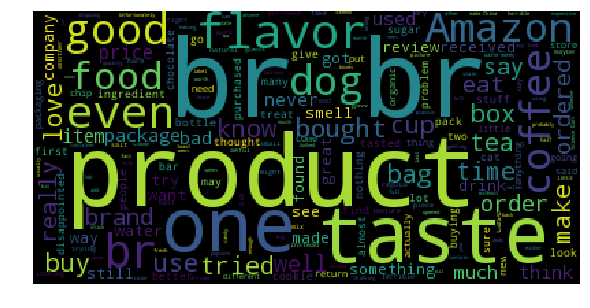

In [14]:
dislike = food_reviews.query("Score == 1")
like = food_reviews.query("Score == 5")
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

#sample_text = "Six Seasons and a Movie!"
#print(text_process(sample_text))
processed_words = text_process(dislike.Text)
processed_words_like = text_process(like.Text)

from wordcloud import WordCloud
#wordcloud = WordCloud(width = 800, height = 600,
#               background_color ='white',
#                min_font_size = 10).generate(processed_words)
wordcloud2 = WordCloud().generate(' '.join(processed_words))
# plot the WordCloud image                       
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

And here's a word cloud for all the 5-star reviews:

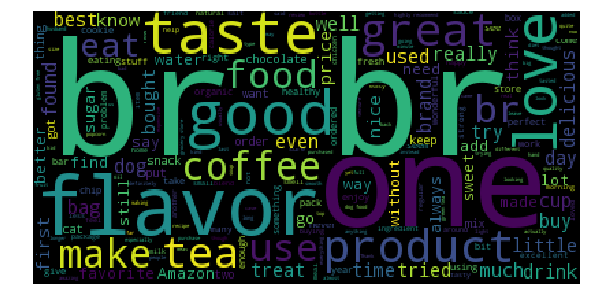

In [15]:
from wordcloud import WordCloud
#wordcloud = WordCloud(width = 800, height = 600,
#               background_color ='white',
#                min_font_size = 10).generate(processed_words)
wordcloud2 = WordCloud().generate(' '.join(processed_words_like))
# plot the WordCloud image                       
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

This was my first NLP project. Any suggestions/ideas/no-dumbass-this-is-how-it's-done is welcome!